In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM

In [2]:
CompanyName = "MRF" #input in capital
df = pd.read_csv(f'/kaggle/input/stock-market-india/FullDataCsv/{CompanyName}__EQ__NSE__NSE__MINUTE.csv')

print(df.head(10))

                   timestamp      open      high       low     close  volume
0  2017-01-02 09:15:00+05:30  48999.00  49304.95  48999.00  49153.10    61.0
1  2017-01-02 09:16:00+05:30  49153.10  49200.00  49060.00  49060.00    39.0
2  2017-01-02 09:17:00+05:30  49060.00  49081.95  49020.65  49020.65    95.0
3  2017-01-02 09:18:00+05:30  49020.65  49043.80  48950.10  48950.10    35.0
4  2017-01-02 09:19:00+05:30  48950.10  49069.70  48950.10  49006.90    76.0
5  2017-01-02 09:20:00+05:30  49006.90  49057.00  49006.90  49011.00    45.0
6  2017-01-02 09:21:00+05:30  49011.00  49050.00  49006.90  49047.00    59.0
7  2017-01-02 09:22:00+05:30  49047.00  49049.95  49014.00  49049.00    16.0
8  2017-01-02 09:23:00+05:30  49049.00  49089.75  49011.05  49050.00    18.0
9  2017-01-02 09:24:00+05:30  49050.00  49052.65  49025.00  49052.55    32.0


In [3]:
print(df.isnull().sum())

timestamp      0
open         205
high         205
low          205
close        205
volume       205
dtype: int64


In [4]:
df.dropna(inplace=True)

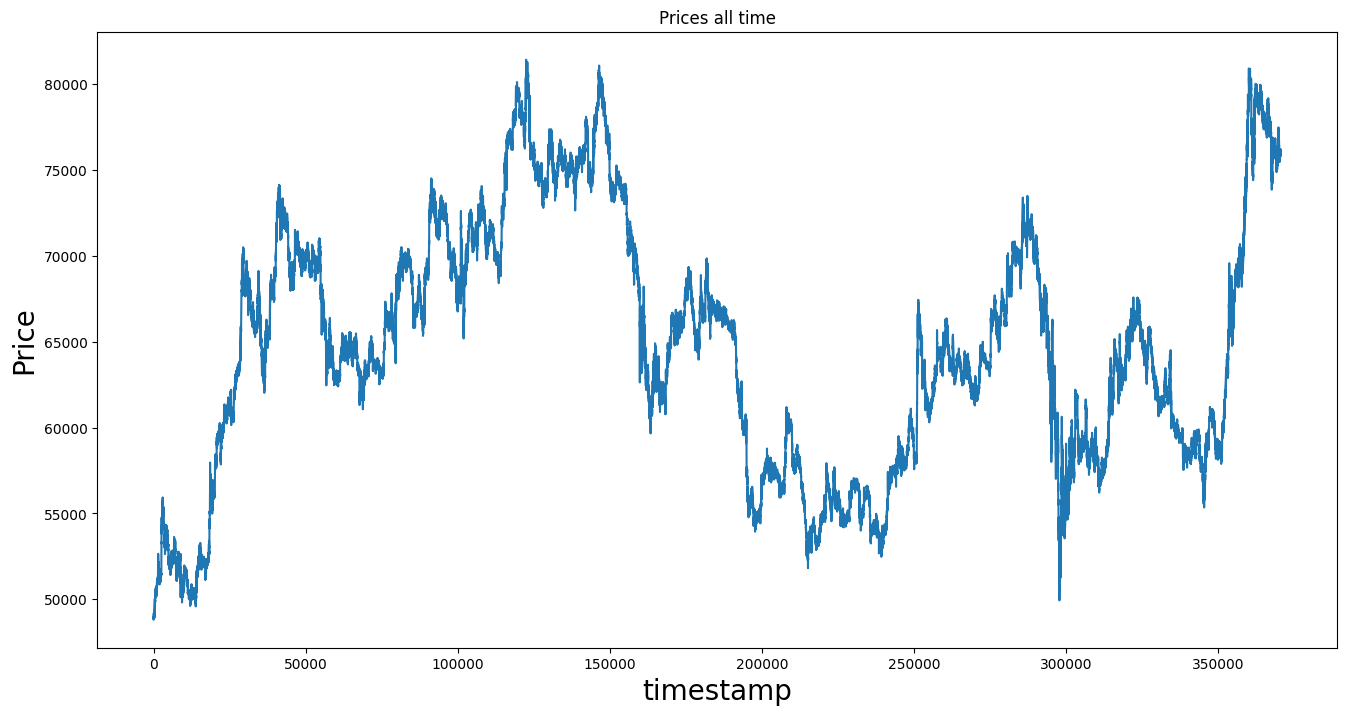

In [5]:
plt.figure(figsize=(16,8))
plt.title('Prices all time')
plt.plot(df['close'])
plt.xlabel('timestamp',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.show()

In [6]:
import math
data = df.filter([ 'close'])
dataset = data.values
train_data_len = math.ceil(len(dataset)* 0.8)
print(f"Total Data Length:{len(dataset)}, Training Data Length:{train_data_len}")

Total Data Length:370340, Training Data Length:296272


In [7]:
dataset

array([[49153.1 ],
       [49060.  ],
       [49020.65],
       ...,
       [76000.  ],
       [76000.  ],
       [76132.  ]])

In [8]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(dataset)

In [9]:
train_data = scaled_data[0:train_data_len]
x_train =[]
y_train =[]

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0]) # Past 60 minutes of closing prices
    y_train.append(train_data[i,0]) # The closing price of the NEXT minute

x_train, y_train = np.array(x_train),np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 25))
model.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile (optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

4629/4629 ━━━━━━━━━━━━━━━━━━━━ 279s 59ms/step - loss: 0.0035


In [13]:
test_data = scaled_data[train_data_len - 60:]

x_test = []
y_test = dataset[train_data_len:, :]  # Original values (for comparison)

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])  # Take last 60 values as input
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
predictions = model.predict(x_test)
predictions= scaler.inverse_transform(predictions)

2315/2315 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step


<ipython-input-15-21d3575afbc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display['Predictions']=predictions


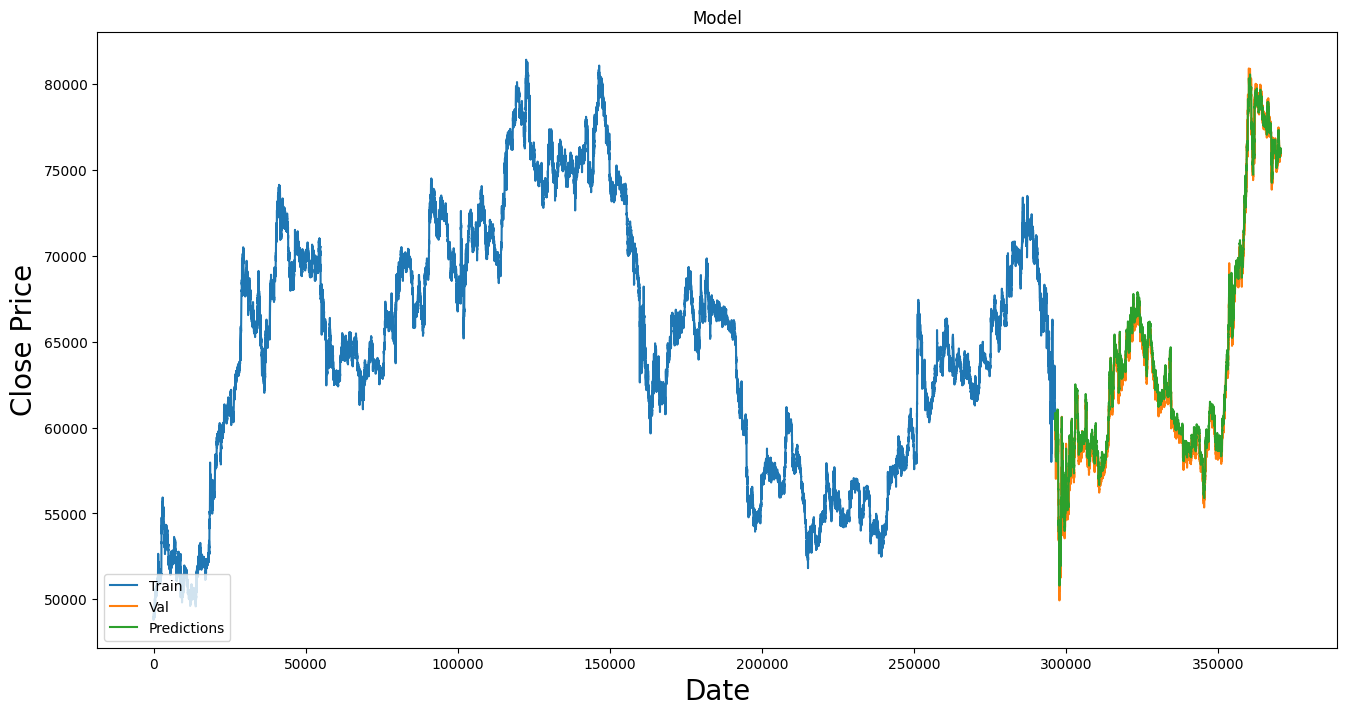

In [15]:
train = data[:train_data_len]
display = data[train_data_len:]
display['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Close Price', fontsize = 20)
plt.plot(train['close'])
plt.plot(display['close'])
plt.plot(display['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')
plt.show()

Mean Squared Error (MSE): 137607.824716899
Root Mean Squared Error (RMSE): 370.95528668142606
Mean Absolute Error (MAE): 335.3130115337426
RÂ² Score: 0.9970649970838276


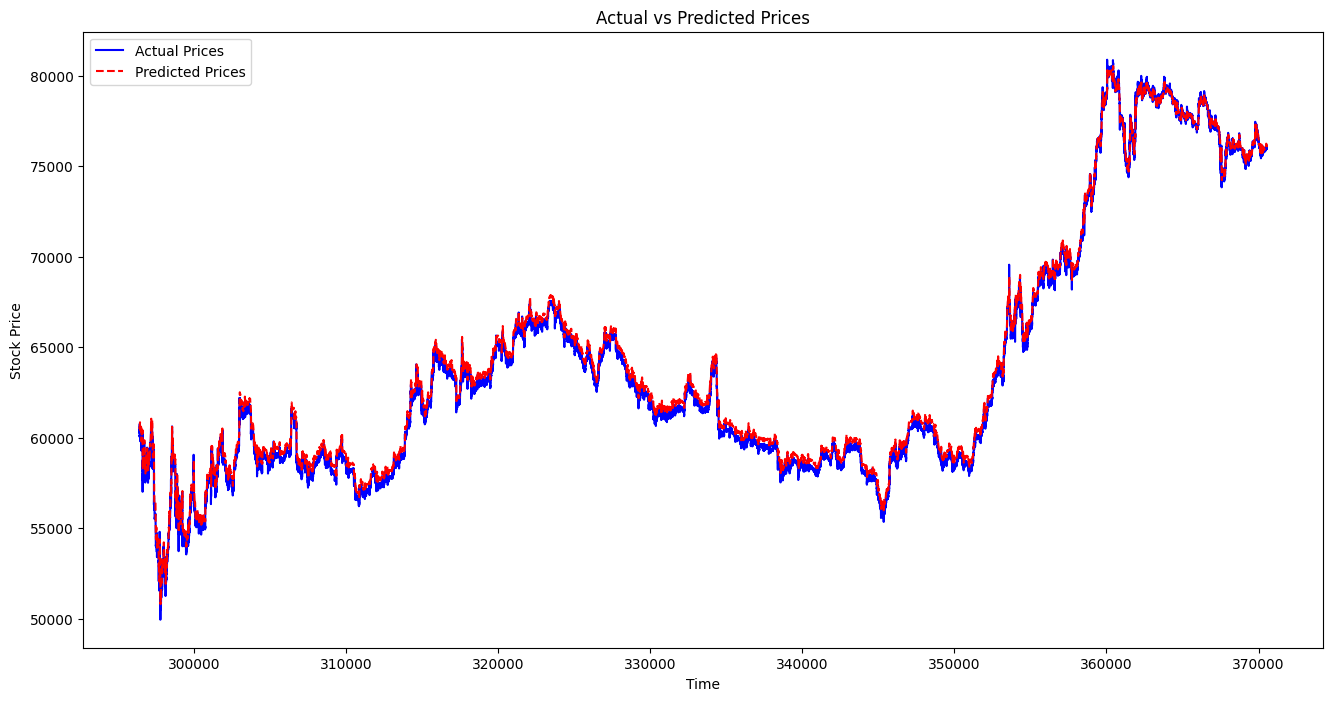

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RÂ² Score: {r2}")

# Visualization 1: Actual vs Predicted Prices
plt.figure(figsize=(16, 8))
plt.plot(display['close'], label='Actual Prices', color='blue')
plt.plot(display['Predictions'], label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
